In [1]:
import torch
import torch.nn as nn
from torchvision import transforms,datasets,models
import numpy as np
import matplotlib.pyplot as plt
import os
from torch.utils.data import random_split
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns


device=  "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

data_path = "data"
print(os.listdir(data_path))





LABELS = ['Curly Hair', 'Straight Hair', 'Wavy Hair']


cuda:0
['Curly Hair', 'Straight Hair', 'Wavy Hair']


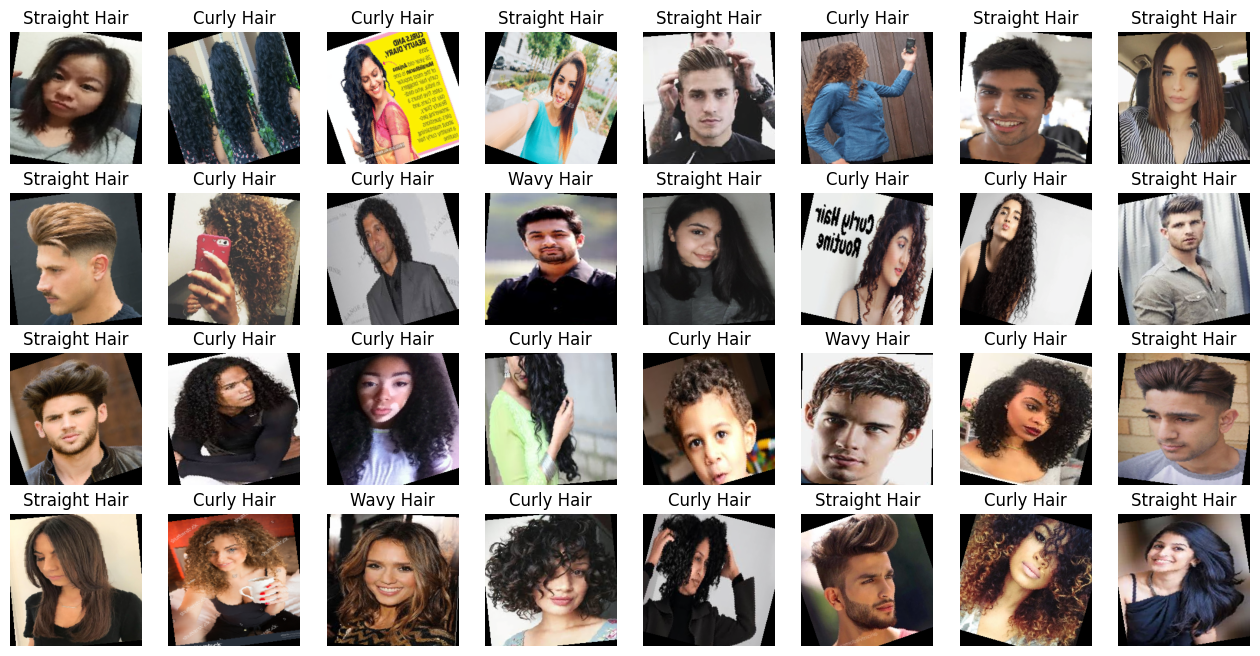

In [2]:

transformed_data = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
    ])



dataset = datasets.ImageFolder(data_path,transformed_data)


train_split = int(len(dataset) * 0.8)
test_split = len(dataset) - train_split

train_data,test_data = random_split(dataset, lengths=[train_split,test_split])


BATCH_SIZE = 32
n_classes = 3
learning_rate = 0.001
epochs = 10



train_dataloader = torch.utils.data.DataLoader(train_data,batch_size=BATCH_SIZE,shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data,batch_size=BATCH_SIZE,shuffle=False)



def img_inv(image):
    image = image.numpy().transpose((1,2,0))
    mean = np.array([0.485,0.456,0.406])
    std = np.array([0.229,0.224,0.225])
    image = image * std + mean
    return np.clip(image,0,1)


images,labels = next(iter(train_dataloader))



fig,axs = plt.subplots(4,8,figsize=(16,8))


for i,ax in enumerate(axs.flat):
    image = img_inv(images[i])
    ax.imshow(image)
    ax.set_title(dataset.classes[labels[i]])
    ax.axis("off")
plt.show()

In [3]:
"""Using resnet18"""


model = models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False


for param in model.layer4.parameters():
    param.requires_grad = True




num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_features,512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512,3)
)

model.to(device)

C:\Program Files\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Program Files\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [4]:
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
criterion = nn.CrossEntropyLoss().to(device)

for epoch in range(epochs):
    running_loss = 0
    for i,(images, labels) in enumerate(train_dataloader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        if (i+1) % 10 == 0:
            print(epoch+1,epochs,i+1,len(train_dataloader),loss.item())


1 10 10 25 0.3655793070793152
1 10 20 25 0.9741185307502747
2 10 10 25 0.42394331097602844
2 10 20 25 0.3507349193096161
3 10 10 25 0.19955313205718994
3 10 20 25 0.09492510557174683
4 10 10 25 0.17275045812129974
4 10 20 25 0.07656041532754898
5 10 10 25 0.2717263996601105
5 10 20 25 0.2513678967952728
6 10 10 25 0.21088288724422455
6 10 20 25 0.17809522151947021
7 10 10 25 0.19015207886695862
7 10 20 25 0.25835737586021423
8 10 10 25 0.03517811745405197
8 10 20 25 0.1665937900543213
9 10 10 25 0.17539221048355103
9 10 20 25 0.02578669600188732
10 10 10 25 0.07190031558275223
10 10 20 25 0.1999289095401764


In [5]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    y_test = []
    y_pred = []
    for images,labels in test_dataloader:
        images,labels = images.to(device),labels.to(device)
        outputs = model(images)
        _,preds = torch.max(outputs.data,1)
        y_pred.extend(preds.cpu().numpy())
        y_test.extend(labels.cpu().numpy())
        total += labels.size(0)
        correct += (preds == labels).sum().item()
        print('Testing Accuracy {} %'.format(100 * correct / total))




print(classification_report(y_test,y_pred))


Testing Accuracy 71.875 %
Testing Accuracy 75.0 %
Testing Accuracy 79.16666666666667 %
Testing Accuracy 80.46875 %
Testing Accuracy 81.875 %
Testing Accuracy 80.20833333333333 %
Testing Accuracy 79.89949748743719 %
              precision    recall  f1-score   support

           0       0.93      0.94      0.94        70
           1       0.71      0.73      0.72        60
           2       0.74      0.71      0.73        69

    accuracy                           0.80       199
   macro avg       0.79      0.80      0.79       199
weighted avg       0.80      0.80      0.80       199



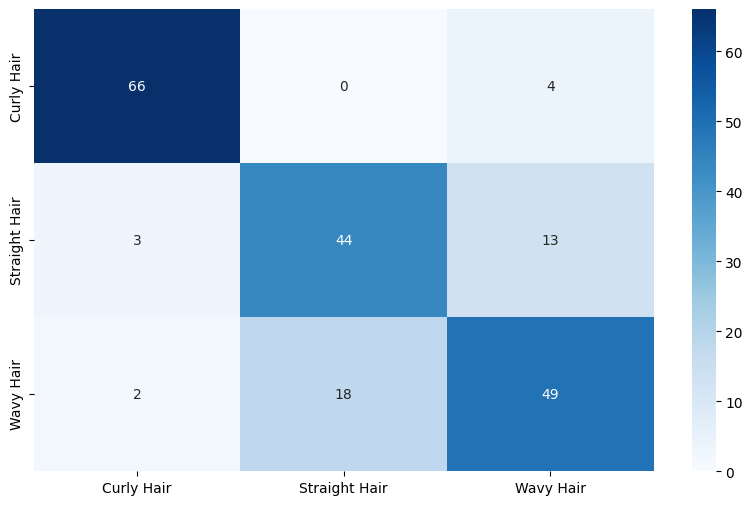

In [6]:
def plot_confusion_matrix(y_test,y_pred):
    cm = confusion_matrix(y_test, y_pred)
    cmap = sns.heatmap(cm,fmt='d',cmap="Blues",annot=True,xticklabels=['Curly Hair','Straight Hair','Wavy Hair'],yticklabels=['Curly Hair', 'Straight Hair', 'Wavy Hair'])
    return cmap


plt.figure(figsize=(10,6))
plot_confusion_matrix(y_test, y_pred)
plt.show()

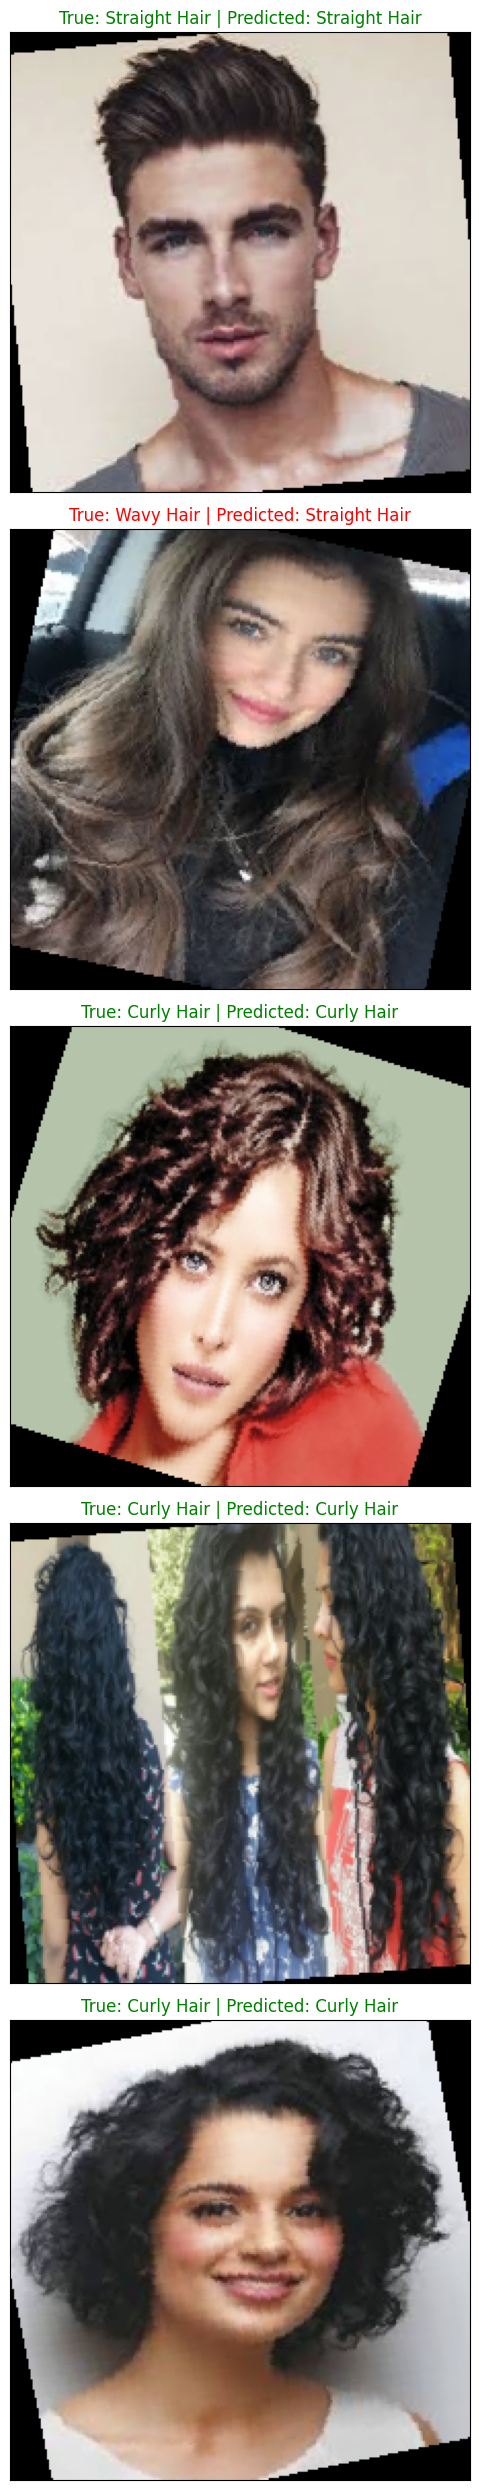

In [7]:
rand_indices = np.random.choice(len(y_pred),size=min(5,len(y_pred)),replace=False)
plt.figure(figsize=(10,5 *len(rand_indices)))
for i, index in enumerate(rand_indices):
    image = img_inv(test_data[index][0])
    plt.subplot(len(rand_indices),1,i+1)
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    predicted_class = dataset.classes[y_pred[index]]
    true_class = dataset.classes[y_test[index]]
    color = 'green' if predicted_class == true_class else 'red'
    plt.title(f'True: {true_class} | Predicted: {predicted_class}', color=color, fontsize=12)

plt.tight_layout()
plt.show()